In [333]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from glob import glob
import re
import requests
import json
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from statsmodels.tsa.stattools import adfuller

In [2]:
import warnings
warnings.filterwarnings("ignore")

### 

### use FinancialPhraseBank-v1.0 data to train model_1

1) import the data from https://huggingface.co/datasets/takala/financial_phrasebank
2) clean the data
3) train model_1
* note model_2 does not require training. It is already pre-trained on financial news

### 

### import the data

In [3]:
glob('*')

['main.ipynb',
 'Vader_and_SBERT.ipynb',
 'train-00001-of-00002-50e0d6558d13575f.parquet',
 'train-00000-of-00002-a3f58f0eb179f9ed.parquet',
 'README.md',
 'FinancialPhraseBank-v1.0']

In [4]:
glob('FinancialPhraseBank-v1.0/*')

['FinancialPhraseBank-v1.0/Sentences_66Agree.txt',
 'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt',
 'FinancialPhraseBank-v1.0/Sentences_50Agree.txt',
 'FinancialPhraseBank-v1.0/README.txt',
 'FinancialPhraseBank-v1.0/License.txt',
 'FinancialPhraseBank-v1.0/Sentences_75Agree.txt']

In [5]:
#use data that have 75% agreement among annotators
data_path = 'FinancialPhraseBank-v1.0/Sentences_75Agree.txt'

with open(data_path, 'r', encoding='utf-8', errors='backslashreplace') as f:
    lines = f.readlines()

In [6]:
lines[:10]

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral\n',
 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .@positive\n',
 "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive\n",
 'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive\n',
 'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .@positive\n',
 'Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .@positive\n',
 "TeliaSonera TLSN said the o

##### 

### clean the data

In [7]:
def break_lines(data_list = list):
    'separate sentence and sentiment tag'
    return [line.split('@') for line in data_list] #have to use re??

def preprocessor(text):
    'remove non-word chars. make text lowercase'
    text = (re.sub('[\W]+',' ', text.lower()))
    return text

def data_wrangle(data_list = list):
    '''
    takes a list of lines and creates a dataframe, where
    the first column contains cleaned phrases, and 
    the second column contains labels 
    '''
    
    ll = break_lines(data_list)    
    
    df = pd.DataFrame(ll, columns = ['sentence','sentiment'])
    
    df.sentence = df.sentence.apply(preprocessor)
    
    #to get rid of the '\n' next to each sentiment
    df.sentiment = df.sentiment.apply(lambda x: x[:-1]) #have to use re??
    
    #labels: Neutral= 0, Positive= 1, Negative= 2
    df['label']=df.sentiment.apply(lambda x: 0 if x=='neutral' else(1 if x=='positive' else -1))
    
    df.drop(columns = ['sentiment'], inplace=True)

    df.drop_duplicates(inplace=True)
    
    df.reset_index(drop=True, inplace=True)
    
    return df

In [8]:
df = data_wrangle(lines)
df.head()

,sentence,label
0,according to gran the company has no plans to ...,0
1,with the new production plant the company woul...,1
2,for the last quarter of 2010 componenta s net ...,1
3,in the third quarter of 2010 net sales increas...,1
4,operating profit rose to eur 13 1 mn from eur ...,1


In [9]:
#check if there are missing values
df.isna().sum()

sentence    0
label       0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  3447 non-null   object
 1   label     3447 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.0+ KB


In [11]:
df.label.value_counts()/df.shape[0]

label
 0    0.620830
 1    0.257325
-1    0.121845
Name: count, dtype: float64

In [12]:
def data_split(dataframe):
    'split the data into balanced train and test sets'
    X = dataframe['sentence']
    y = dataframe['label']
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
    train_ind, test_ind = next(sss.split(X,y,groups=None))
    
    X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]
    
    return X_train, y_train, X_test, y_test

In [13]:
X_train, y_train, X_test, y_test = data_split(df)

In [14]:
y_train.value_counts()/y_train.shape[0]

label
 0    0.620965
 1    0.257164
-1    0.121872
Name: count, dtype: float64

#### 

### train model 1 - Term Frequency-Inverse Document Frequency (TF-IDF), Multinomial Logistic Regression

In [15]:
def tokenizer(text):
    return text.split()

In [17]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer = tokenizer,
                        token_pattern=None)

lr_tfidf = Pipeline([('vect',tfidf),
                     ('clf',OneVsRestClassifier(LogisticRegression(random_state=123,   #multinomial classifier
                                                                   solver='newton-cg',
                                                                   penalty='l2',
                                                                   class_weight ='balanced')))])     

In [18]:
param_grid = [
    {
        'vect__ngram_range': [(1,1)],
        'vect__max_df':[.25,.5,.75],
        #'vect__tokenizer': [tokenizer,tokenizer_porter], # try with and without stemming
        
        'clf__estimator__C':[1.0,10.0,100.0],
    },
    {
        'vect__ngram_range': [(1,2)],                    # try both unigram and bigram
        'vect__max_df':[.25,.5,.75],
        #'vect__tokenizer': [tokenizer,tokenizer_porter],
        'vect__use_idf': [False],                        # try using term frequencies without tf-idf
        'vect__norm': [None],                            # turn off norming when using tf
        
        'clf__estimator__C': [1.0,10.0,100.0]
    }
    ]

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
gs_lr_tfidf.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False,
                                                        token_pattern=None,
                                                        tokenizer=<function tokenizer at 0x7fe92039edc0>)),
                                       ('clf',
                                        OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                                         random_state=123,
                                                                                         solver='newton-cg')))]),
             n_jobs=-1,
             param_grid=[{'clf__estimator__C': [1.0, 10.0, 100.0],
                          'vect__max_df': [0.25, 0.5, 0.75],
                          'vect__ngram_range': [(1, 1)]},
                         {'clf__estimator__C': [1.0, 10.0, 100.0],
                          'vect__max_df': [0.25, 0.5, 0.75],
                          'vect__ngram_range': [(1, 2)], 'vect__norm': [None],
                          'vect__use_idf': [False]}],
             scoring='accuracy')

In [19]:
print(f'Best parameter set: {gs_lr_tfidf.best_params_}')
print(f'CV Accuracy: {gs_lr_tfidf.best_score_:0.3f}')

Best parameter set: {'clf__estimator__C': 10.0, 'vect__max_df': 0.25, 'vect__ngram_range': (1, 2), 'vect__norm': None, 'vect__use_idf': False}
CV Accuracy: 0.858


In [20]:
model_1 = gs_lr_tfidf.best_estimator_
print(f'Test Accuracy: {model_1.score(X_test, y_test):0.3f}')

Test Accuracy: 0.851


###### 

In [21]:
# test using new examples
txt = 'Tesla reports 7% drop in auto revenue as earnings fall short of Wall Street estimates'
txt_p = preprocessor(txt)
txt_p

'tesla reports 7 drop in auto revenue as earnings fall short of wall street estimates'

In [22]:
model_1.predict([txt_p]), np.round(model_1.predict_proba([txt_p]))

(array([0]), array([[0., 1., 0.]]))

In [23]:
txt_2 = 'Tesla reported weaker-than-expected earnings for the second quarter as automotive sales dropped for a second straight period.'
txt_2_p = preprocessor(txt_2)
txt_2_p

'tesla reported weaker than expected earnings for the second quarter as automotive sales dropped for a second straight period '

In [24]:
model_1.predict([txt_2_p]), np.round(model_1.predict_proba([txt_2_p]))

(array([-1]), array([[1., 0., 0.]]))

In [25]:
txt_3 = 'Sonim Technologies Inc . (NASDAQ:SONM) director Jeffrey Wang recently sold company shares, generating a total of over $5,900 in the process. '
txt_3_p = preprocessor(txt_3)
txt_3_p

'sonim technologies inc nasdaq sonm director jeffrey wang recently sold company shares generating a total of over 5 900 in the process '

In [26]:
model_1.predict([txt_3_p]), np.round(model_1.predict_proba([txt_3_p]))

(array([0]), array([[0., 1., 0.]]))

In [27]:
model_1

Pipeline(steps=[('vect',
                 TfidfVectorizer(lowercase=False, max_df=0.25,
                                 ngram_range=(1, 2), norm=None,
                                 token_pattern=None,
                                 tokenizer=<function tokenizer at 0x7fe92039edc0>,
                                 use_idf=False)),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=10.0,
                                                                  class_weight='balanced',
                                                                  random_state=123,
                                                                  solver='newton-cg')))])

#### 

### model 2 - FinBERT

note: the FinBERT model is large. codes below may take a while to run

In [28]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [122]:
tokenizer_2 = AutoTokenizer.from_pretrained("ProsusAI/finbert")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

In [30]:
X_test

2088    pohjola and cooperative banks have continued t...
815     basware order matching automatically matches p...
2404    why not give your bedroom a cool makeover for ...
3228    earlier today geberit s finnish rival uponor o...
1132    a flurry analytics spokesperson said that as i...
                              ...                        
1280    aspo s net sales in 2006 totaled eur 225 9 mil...
2617    qpr processguide is available as a system solu...
2632    stora enso will receive a 19 9 pct equity inte...
1427    the company turned to earnings per share eps o...
1347    finnish aluminium products manufacturer nordic...
Name: sentence, Length: 690, dtype: object

In [31]:
X_test_list = X_test.to_list()

In [32]:
inputs = tokenizer_2(X_test_list, padding = True, truncation = True, return_tensors='pt')
print(inputs)

{'input_ids': tensor([[  101, 13433,  2232,  ...,     0,     0,     0],
        [  101, 19021,  8059,  ...,     0,     0,     0],
        [  101,  2339,  2025,  ...,     0,     0,     0],
        ...,
        [  101,  2358,  6525,  ...,     0,     0,     0],
        [  101,  1996,  2194,  ...,     0,     0,     0],
        [  101,  6983, 14794,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [33]:
outputs = model_2(**inputs)
print(outputs.logits.shape)

torch.Size([690, 3])


In [34]:
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[0.0533, 0.0123, 0.9344],
        [0.0295, 0.0322, 0.9383],
        [0.0907, 0.0147, 0.8946],
        ...,
        [0.0794, 0.0093, 0.9113],
        [0.8980, 0.0248, 0.0771],
        [0.0526, 0.0222, 0.9252]], grad_fn=<SoftmaxBackward0>)


In [35]:
predictions_list = predictions.tolist()
label = []

for pred in predictions_list:
    max_prob = max(pred)
    ind = pred.index(max_prob)
    if ind == 0:
        l = 1
    elif ind == 1:
        l = -1
    else:
        l = 0
    label.append(l)

In [36]:
X_test_2 = X_test.copy()
X_test_2.reset_index(drop=True, inplace=True)
y_test_2 = y_test.copy()
y_test_2.reset_index(drop=True, inplace=True)

In [37]:
df = pd.concat([X_test_2,y_test_2],axis=1)
df['predicted_label'] = label
df

,sentence,label,predicted_label
0,pohjola and cooperative banks have continued t...,0,0
1,basware order matching automatically matches p...,0,0
2,why not give your bedroom a cool makeover for ...,0,0
3,earlier today geberit s finnish rival uponor o...,-1,-1
4,a flurry analytics spokesperson said that as i...,0,0
...,...,...,...
685,aspo s net sales in 2006 totaled eur 225 9 mil...,0,0
686,qpr processguide is available as a system solu...,0,0
687,stora enso will receive a 19 9 pct equity inte...,0,0
688,the company turned to earnings per share eps o...,1,1


In [38]:
df.predicted_label.value_counts()

predicted_label
 0    413
 1    186
-1     91
Name: count, dtype: int64

In [39]:
accuracy = (df.label == df.predicted_label).mean()
print(f'FinBERT\'s Test Accuracy: {accuracy:0.3f}')

FinBERT's Test Accuracy: 0.955


### 

### predict sentiment about a stock in historical financial news

* import news dataset from https://huggingface.co/datasets/ashraq/financial-news-articles
* feed the data to FinBERT and receive timeseries sentiment predictions

### import the data

In [40]:
glob('*')

['main.ipynb',
 'Vader_and_SBERT.ipynb',
 'train-00001-of-00002-50e0d6558d13575f.parquet',
 'train-00000-of-00002-a3f58f0eb179f9ed.parquet',
 'README.md',
 'FinancialPhraseBank-v1.0']

In [41]:
df_news_1 = pd.read_parquet('train-00000-of-00002-a3f58f0eb179f9ed.parquet', engine='pyarrow')
df_news_2 = pd.read_parquet('train-00001-of-00002-50e0d6558d13575f.parquet', engine='pyarrow')

In [42]:
#alternatively, 
#from datasets import load_dataset
#ds = load_dataset("ashraq/financial-news-articles")

In [43]:
df_news = pd.concat([df_news_1,df_news_2])

In [44]:
df_news.drop_duplicates(inplace=True)
df_news.reset_index(drop=True, inplace=True)

In [45]:
df_news.head()

,title,text,url
0,BRIEF-Bigger Capital Fund Reports An 8 Pct Pas...,"January 2, 2018 / 9:31 PM / Updated 8 minutes ...",https://www.reuters.com/article/brief-bigger-c...
1,Global Markets: Asia shares reach decade top o...,NEW YORK (Reuters) - European stocks closed lo...,https://in.reuters.com/article/global-markets/...
2,Donald Trump is the only person in Washington ...,Fears of a government shutdown coursed through...,https://www.cnbc.com/2018/01/18/donald-trump-t...
3,Actor Casey Affleck withdraws as 2018 Oscar pr...,03 PM / Updated 19 minutes ago Actor Casey Af...,https://www.reuters.com/article/us-oscars-case...
4,EU mulls new link between budget and civic rights,"January 22, 2018 / 7:23 PM / Updated 2 hours a...",https://uk.reuters.com/article/uk-eu-poland-bu...


In [46]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306239 entries, 0 to 306238
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   306239 non-null  object
 1   text    306239 non-null  object
 2   url     306239 non-null  object
dtypes: object(3)
memory usage: 7.0+ MB


### prepare df_news for sentiment prediction

In [47]:
def extract_newsletter_name(url):
    'extracts newsletter name from url'
    pattern = r'^.+://([\w]*\.*[\w]+)\.com.*'
    name = re.findall(pattern,url)[0]
    name = name.split('.')[-1]
    return name

def extract_date_from_url(url):
    'extracts date from url'
    pattern = r'^.*\/([\d]{4}\/[\d]{2}\/[\d]{2}).*'
    dates = re.findall(pattern,url)
    if len(dates) != 0:
        date = dates[0]
    else:
        date = np.nan
    return date
    
def extract_date_from_article(article):
    'extracts date from article'
    miss_spelling_jan = 'Janauary'
    miss_spelling_feb = 'Febuary'
    
    len_ms_jan = len(miss_spelling_jan)
    len_ms_feb = len(miss_spelling_feb)
    
    pattern = r'([A-Z][a-z]+ [\d]{1,2}, [\d]{4}).*'
    dates = re.findall(pattern,article)
    if len(dates) != 0:
        date = dates[0]
        if date.startswith('Janauary'):
            date = 'January' + date[len_ms_jan:]
        elif date.startswith('Febuary'):
            date = 'February' + date[len_ms_feb:]
    else:
        date = np.nan
    return date

In [48]:
'''
df_news will be cleaned to remove rows where dates cannot be identified from articles or urls.
final df_news_processed contains the following columns: date, newspaper name, article titile, article, url and a helper column.
'''
#create the date column
df_news_processed = df_news.copy()
df_news_processed['date_from_url'] = df_news_processed.url.apply(extract_date_from_url)
df_news_processed['date_from_article'] = df_news_processed.text.apply(extract_date_from_article)
df_news_processed['date'] = df_news_processed['date_from_url'].combine_first(df_news_processed['date_from_article'])

#will only use news articles where dates can be extracted 
df_news_processed = df_news_processed[df_news_processed.date.notna()]

#change date from list data type to timestamp 
df_news_processed.date = df_news_processed.date.apply(lambda x: pd.to_datetime(x, errors='coerce'))
df_news_processed = df_news_processed[df_news_processed.date.notna()]

df_news_processed.drop(columns = ['date_from_url', 'date_from_article'], inplace=True)

df_news_processed['newspaper'] = df_news_processed.url.apply(extract_newsletter_name)

df_news_processed.reset_index(drop=True, inplace=True)

new_order = ['date', 'newspaper', 'title', 'text', 'url']
df_news_processed = df_news_processed.reindex(columns=new_order)
df_news_processed.rename(columns = {'text':'article'}, inplace=True)

#the helper column will be needed later for storing processed articles
df_news_processed['helper'] = None

In [49]:
df_news_processed

,date,newspaper,title,article,url,helper
0,2018-01-02,reuters,BRIEF-Bigger Capital Fund Reports An 8 Pct Pas...,"January 2, 2018 / 9:31 PM / Updated 8 minutes ...",https://www.reuters.com/article/brief-bigger-c...,None
1,2018-01-02,reuters,Global Markets: Asia shares reach decade top o...,NEW YORK (Reuters) - European stocks closed lo...,https://in.reuters.com/article/global-markets/...,None
2,2018-01-18,cnbc,Donald Trump is the only person in Washington ...,Fears of a government shutdown coursed through...,https://www.cnbc.com/2018/01/18/donald-trump-t...,None
3,2018-01-22,reuters,EU mulls new link between budget and civic rights,"January 22, 2018 / 7:23 PM / Updated 2 hours a...",https://uk.reuters.com/article/uk-eu-poland-bu...,None
4,2018-01-23,reuters,BRIEF-Sandridge Energy Rejects Icahn's Proposa...,"January 23, 2018 / 9:42 PM / Updated 10 minute...",https://www.reuters.com/article/brief-sandridg...,None
...,...,...,...,...,...,...
185698,2018-05-04,cnbc,QIC Expands Senior Leadership Team in U.S. and...,"NEW YORK and LOS ANGELES, May 4, 2018 /PRNewsw...",http://www.cnbc.com/2018/05/04/pr-newswire-qic...,None
185699,2018-05-08,reuters,"Fissures spread from Hawaii volcano, threateni...","May 8, 2018 / 10:16 AM / Updated an hour ago F...",https://uk.reuters.com/article/uk-hawaii-volca...,None
185700,2018-05-17,reuters,British gaming firm enlists army of players to...,"May 17, 2018 / 10:22 AM / Updated 39 minutes a...",https://www.reuters.com/article/us-videogames-...,None
185701,2018-05-31,cnbc,JMU Limited Reports Unaudited First Quarter 20...,"SHANGHAI, May 31, 2018 /PRNewswire/ -- JMU Lim...",http://www.cnbc.com/2018/05/31/pr-newswire-jmu...,None


### 

### feed the data to the more accurate model and receive timeseries-sentiment predictions

In [80]:
class Empty(Exception):
    pass

def split_article(art):
    art = art.split('\n')
    art_split = []
    for line in art:
        art_split.append(preprocessor(line))
    return art_split

def calc_sentiment(art, model):
    '''
    how to properly calculate the sentiment of a piece of newspaper article?
    things that need to be considered:
        - many sentences in an article may contain neutral sentiment. taking the average of the sentiments of all sentences "dilutes" the overall sentiment
          solution (that i propose and is adopted in this function): take the average of nonzero (non-neutral) sentiments only 
        - the "weights" of sentiment of non-neutral sentences differ as they carry different kinds of information. how should this be quantified?
          e.g., two positive sentences both receive 1 score. however, sentence 1 may influence traders' decisions more than sentence 2
          solution: none yet. will assume equal weights as assuming otherwise would require a different model that assigns continuous numerical values as scores
    '''
    sent_scores = []
    
    if model == model_1:
        for line in art:
            sent = model.predict([line])
            
            #exclude neutral sentiments
            if sent != 0:
                sent_scores.append(sent[0])
            
    else:
        inputs = tokenizer_2(art, padding = True, truncation = True, return_tensors='pt')
        outputs = model_2(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predictions_list = predictions.tolist()

        for pred in predictions_list:
            max_prob = max(pred)
            ind = pred.index(max_prob)
            if ind == 0:
                sent = 1
            elif ind == 1:
                sent = -1
            else:
                sent = 0
            
            #exclude neutral sentiments
            if sent != 0:
                sent_scores.append(sent)

    sent_sum = np.sum(sent_scores)

    #the function returns not just an article's sentiment sum, it also returns the number of 'sentimented' lines. this number
    #will be used later for getting a daily average sentiment
    
    return sent_sum, len(sent_scores)

def calc_avg_daily_sentiment(group):
    '''
    after all the article sentiments are aggregated by date, this function divides sentiment_sum by sentiment_count
    '''
    if group['sentiment_count'].sum() != 0:
        return group['sentiment_sum'].sum()/group['sentiment_count'].sum()
    else:
        return np.nan

In [250]:
class SentimentDataFrames():
    
    def __init__(self, df_news_processed, model):
        self.df = df_news_processed
        self.comp_df = pd.DataFrame()
        self.comp_sent_df = pd.DataFrame()
        self.model = model
    
    def get_comp_df(self, comp_name):
        '''
        in this method, intermediate columns will be added to df_news_processed to get an averaged sentiment score for an artile.
        the method first makes a copy of self.df and filter for articles about the specified company, comp_name, then calculates the average sentiment.
        it then further filters for the year where there are the highest number of articles 
        the end result is a dataframe that contains the following columns: date, year, newspaper name, article titile, article, url, 
        processed_article, processed_title, sentiment_sum, and sentiment_count.
        '''
        if 'helper' not in self.df.columns:
            raise Empty('News data has not been processed!')
        
        self.comp_df = self.df.copy()
        
        self.comp_df['processed_title'] = self.comp_df.title.apply(preprocessor)
        self.comp_df['processed_title'] = self.comp_df['processed_title'].apply(tokenizer)
        self.comp_df.helper = self.comp_df['processed_title'].apply(lambda x: comp_name in x)

        self.comp_df = self.comp_df[self.comp_df.helper==True]
        
        self.comp_df.helper = self.comp_df.article.apply(split_article)
        
        self.comp_df['sentiment_sum'] = self.comp_df.helper.apply(lambda x: calc_sentiment(x, self.model)[0])
        
        self.comp_df['sentiment_count'] = self.comp_df.helper.apply(lambda x: calc_sentiment(x, self.model)[1])
        
        self.comp_df.sort_values('date',inplace=True)
        
        self.comp_df['year'] = self.comp_df.date.dt.year
        
        #retaining the year that has the largest number of articles
        self.comp_df = self.comp_df[self.comp_df.year == self.comp_df.year.value_counts().idxmax()] 
        
        self.comp_df.rename(columns={'helper':'processed_article'}, inplace=True)
        
        self.comp_df.reset_index(drop=True, inplace=True)
        
        return self.comp_df
    
    def get_comp_sentiments(self):
        '''
        in this method, all the article sentiments will be aggregated by date. 
        the resulting score is an average of the articles published on the same day
        '''
        self.comp_sent_df = self.comp_df.copy()
        self.comp_sent_df = self.comp_sent_df.groupby('date', as_index=False).apply(lambda group: pd.Series({
            'avg_sentiment': calc_avg_daily_sentiment(group)}))
        
        self.comp_sent_df.set_index('date', inplace=True)
        self.comp_sent_df.fillna(method = 'ffill', inplace=True)
        
        return self.comp_sent_df


In [339]:
class SentimentGraph():
    '''
    this class contains the company name and company sentiment dataframe attributes.
    its method creates two time series graphs about the sentiments.
    '''
    def __init__(self, comp_name, comp_sent_df):
        self.comp_sent_df = comp_sent_df
        self.comp_name = comp_name.capitalize()

    def get_sent_graphs(self):
        fig,ax = plt.subplots(2,1,figsize=(20,8))
        
        #bar chart
        colors = ['blue' if val > 0 else 'red' for val in self.comp_sent_df.avg_sentiment]
        bars = ax[0].bar(self.comp_sent_df.index, self.comp_sent_df.avg_sentiment, color = colors)

        ax[0].set_title(f'Time Series Bar Chart for {self.comp_name} Sentiment', fontsize=12)
        ax[0].set_xlabel('Date', fontsize=12)
        ax[0].set_ylabel('Average Sentiment', fontsize=12)
        ax[0].grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
        ax[0].tick_params(rotation=90) 
        ax[0].minorticks_on()
        
        #line graph
        ax[1].plot(self.comp_sent_df.index, self.comp_sent_df.avg_sentiment, marker='o', color='cyan', alpha=0.75)
        ax[1].set_facecolor('black')
        ax[1].set_title(f'Time Series Line Graph for {self.comp_name} Sentiment', fontsize=12)
        ax[1].set_xlabel('Date', fontsize=12)
        ax[1].set_ylabel('Average Sentiment', fontsize=12)
        ax[1].grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
        ax[1].minorticks_on()
        ax[1].tick_params(axis='x', rotation=90)

        plt.tight_layout()
        plt.show()
        return None

In [269]:
class StockPriceDataFrame():
    '''
    this class stores the information that is necessary for calling an API and downloading the historical stock prices of a company.
    the method transforms stock prices in json file to a dataframe.
    '''
    def __init__(self, symbol):
        self.base_url = 'https://www.alphavantage.co/query?'
        self.api_key = '5O74RRM09BLCB723'
        self.symbol = symbol.upper()
        self.params={'function':'TIME_SERIES_DAILY',
                     'symbol': self.symbol,
                     'apikey': self.api_key,
                     'outputsize': 'full',
                     'datatype': 'json'
                     }
        self.sprice_df = pd.DataFrame()
        
    def get_stockprices(self):
        '''
        the final stock price df contains date and price columns.
        the price column contains close prices for weekdays and Mondays' open prices for weekends.
        date is in datetime format. price is a float datatype.
        '''
        results = requests.get(self.base_url, params=self.params)
        assert results.status_code == 200, 'Something wrong!'
        raw = results.json()

        placeholder_dict = {'date':[],
                             'open':[],
                             'close':[],            
                             }

        for date in raw['Time Series (Daily)']:
            placeholder_dict['date'].append(date)
            placeholder_dict['open'].append(raw['Time Series (Daily)'][date]['1. open'])
            placeholder_dict['close'].append(raw['Time Series (Daily)'][date]['4. close'])

        self.sprice_df = pd.DataFrame(placeholder_dict)
        self.sprice_df.date = self.sprice_df.date.apply(lambda x: pd.to_datetime(x))
        
        self.sprice_df.set_index('date', inplace=True)
        
        #create a complete date range from the start to the end
        full_date_range = pd.date_range(start=self.sprice_df.index.min(), end=self.sprice_df.index.max(), freq='D')
        
        #reindex sprice_df to include all dates in the full date range
        self.sprice_df = self.sprice_df.reindex(full_date_range)
        
        #backfill open prices so that weekend's open equal following monday's open
        self.sprice_df.open.fillna(method = 'bfill', inplace=True)
        
        #fill close col with values from open
        self.sprice_df.close = self.sprice_df.close.combine_first(self.sprice_df.open)
        
        self.sprice_df.drop(columns = ['open'], inplace=True)
        
        self.sprice_df.rename(columns = {'close':'price'}, inplace=True)
        
        self.sprice_df.price = self.sprice_df.price.astype(float)                
        
        return self.sprice_df
                        

In [282]:
class MergedDataFrame():
    '''
    this class contains data frames as its attributes.
    its method merges a company's newspaper sentments and stock prices into one data frame.
    '''
    def __init__(self, sentiment_df, stock_df):
        self.sent_df = sentiment_df
        self.stock_df = stock_df
        self.merged_df = pd.DataFrame()

    def get_merged_df(self):
        '''
        in this method, sentiment and stock prices dataframes are merged.
        left join is used to pull in prices for the dates when the news were published, as well as prices two days prior to the publication,
        and prices three days prior. 
        the rationale behind this algorithm is that the articles in the data all come from sources such as wsj, reuters, where publication of
        information is delayed by 2 to 3 days, meaning newspaper writers read financial analyses (not from wsj and reuters) on day 0 and then write an artile.
        by the time the publication is out in wsj, the analyses have been available to the public for about 2 to 3 days. 
        such information should already be reflected in the stock price.
        
        therefore, price change percentage is calculated by: (the price on the date of publication (sentiment date) - the price two days prior)/ 
        the price two days prior * 100
        '''
        self.merged_df = pd.merge(self.sent_df, self.stock_df, left_index = True, right_index=True)
        
        self.merged_df['date'] = self.merged_df.index
        self.merged_df['prior_2d'] = self.merged_df.date + pd.DateOffset(days=-2)
        
        self.merged_df = pd.merge(self.merged_df, self.stock_df, how='left', left_on='prior_2d',right_index=True, suffixes = (None, '_2d_lag'))
        
        self.merged_df.drop(columns = ['date'],inplace=True) 
        
        new_order = ['avg_sentiment', 'price', 'prior_2d', 'price_2d_lag']
        self.merged_df = self.merged_df.reindex(columns=new_order)
        
        self.merged_df['price_diff'] = (self.merged_df.price - self.merged_df.price_2d_lag)/self.merged_df.price_2d_lag*100
        
        return self.merged_df
        

In [344]:
class Correlation():
    '''
    this class contains methods for evaluting the correlation between a stock's newspaper sentiments and prices
    '''
    def __init__(self, merged_df):
        self.merged_df = merged_df
        
    def get_corr(self):
        'this method returns the correlation between sentiment and prices'
        
        #use Augmented Dickey-Fuller (ADF) test to check for stationarity
        #the null hypothesis of the test is root = 1 (unit root, meaning the time series is non-stationary)
        
        sent_result = adfuller(self.merged_df.avg_sentiment)
        price_diff_result = adfuller(self.merged_df.price_diff)
        
        #if both time series are stationary (p values are small enough to reject null hypotheses), then we will use pearson correlation method
        if sent_result[1] < 0.05 and price_diff_result[1] < 0.05:
            corr = self.merged_df.avg_sentiment.corr(self.merged_df.price_diff, method='pearson')
            print(f'There correlation between sentiment and stock price is {corr:.2f}.')
            return round(corr,2)
        else:
            raise ValueError("Both time series must be stationary to compute Pearson correlation.\
            ADF test failed to reject the null hypothesis for one or both series.")
    
    def get_scatterplot(self):
        'this method graphs the scatterplot and linear regression line between sentiment and prices'
        
        plt.figure(figsize=(10, 2))
        sns.lmplot(x='avg_sentiment', y='price_diff', data=self.merged_df, scatter_kws={'alpha':0.75})
        plt.title('Scatter Plot between Sentiment and Stock Price', fontsize=15)
        plt.xlabel('Average Sentiment', fontsize=12)
        plt.ylabel('2-Day-Lag Price Change (%)', fontsize=12)
        plt.show()
        
        return None
    
    def get_timeseriesplot(self):
        'this method outputs a time series plot that compares sentiments and stock price changes side by side'
        date = self.merged_df.index.to_list()
        plt.figure(figsize=(20, 6))
        sns.lineplot(x=date, y='price_diff', marker='o', alpha=0.75, data=self.merged_df) 
        plt.title('Time Series Plot', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Average Sentiment, 2-Day-Lag Stock Price Change (%)', fontsize=12)
        plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5) 
        plt.minorticks_on()
        plt.xticks(rotation=90)

        colors = ['blue' if val > 0 else 'red' for val in self.merged_df.avg_sentiment]
        bars = plt.bar(date, self.merged_df.avg_sentiment, color = colors, alpha=0.75)
        
        legend_elements = [
            Line2D([0], [0], color='b', lw=2, label='Price Difference %'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Positive Sentiment'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Negative Sentiment')
        ]

        plt.legend(handles=legend_elements, loc='upper left', fontsize=12)
        plt.show()
        
        return None
        

#### 

#### test program using Apple & model 1

In [251]:
test = SentimentDataFrames(df_news_processed,model_1)

In [252]:
comp_df = test.get_comp_df('apple')
comp_df

,date,newspaper,title,article,url,processed_article,processed_title,sentiment_sum,sentiment_count,year
0,2018-01-02,cnbc,Sell Apple on battery life canard? No!: Jim Cr...,Sell Apple on battery life canard? No!: Jim Cr...,https://www.cnbc.com/video/2018/01/02/sell-app...,[sell apple on battery life canard no jim cram...,"[sell, apple, on, battery, life, canard, no, j...",0.0,0,2018
1,2018-01-02,cnbc,Cramer Remix: My prediction for Apple in 2018,Cramer Remix: My prediction for Apple in 2018 ...,https://www.cnbc.com/video/2018/01/02/cramer-r...,[cramer remix my prediction for apple in 2018 ...,"[cramer, remix, my, prediction, for, apple, in...",-1.0,1,2018
2,2018-01-02,cnbc,Cramer: Apple's iPhone 'batterygate' issue doe...,3 Hours Ago | 01:23 \nApple 's iPhone battery ...,https://www.cnbc.com/2018/01/02/cramer-apples-...,"[3 hours ago 01 23 , apple s iphone battery pr...","[cramer, apple, s, iphone, batterygate, issue,...",-1.0,1,2018
3,2018-01-02,fortune,Apple Admits To Slowing iPhones With Aging Bat...,An Apple Conspiracy Theory Blooms Poravute By ...,http://fortune.com/2018/01/02/an-apple-conspir...,[an apple conspiracy theory blooms poravute by...,"[apple, admits, to, slowing, iphones, with, ag...",1.0,1,2018
4,2018-01-02,fortune,Trump's Tax Plan Means Apple Can Netflix and C...,By Hallie Detrick 9:20 AM EST \nThere’s a 40% ...,http://fortune.com/2018/01/02/apple-can-netfli...,"[by hallie detrick 9 20 am est , there s a 40 ...","[trump, s, tax, plan, means, apple, can, netfl...",0.0,0,2018
...,...,...,...,...,...,...,...,...,...,...
1352,2018-05-31,cnbc,Evergreen Bets Big on Disrupting the IT Market...,SAN FRANCISCO--(BUSINESS WIRE)-- Evergreen Ser...,http://www.cnbc.com/2018/05/31/business-wire-e...,[san francisco business wire evergreen service...,"[evergreen, bets, big, on, disrupting, the, it...",3.0,3,2018
1353,2018-05-31,reuters,Telegram says Apple has prevented it from upda...,"May 31, 2018 / 9:48 AM / a few seconds ago Tel...",https://www.reuters.com/article/us-russia-tele...,[may 31 2018 9 48 am a few seconds ago telegra...,"[telegram, says, apple, has, prevented, it, fr...",4.0,4,2018
1354,2018-05-31,reuters,Apple cuts smartphone power chip orders from D...,"May 31, 2018 / 5:36 PM / Updated 3 hours ago A...",https://in.reuters.com/article/apple-power-chi...,[may 31 2018 5 36 pm updated 3 hours ago apple...,"[apple, cuts, smartphone, power, chip, orders,...",0.0,4,2018
1355,2018-05-31,fortune,Telegram CEO Says Apple Refuses to Update App ...,The CEO of the secure-messaging app Telegram i...,http://fortune.com/2018/05/31/telegram-apple-a...,[the ceo of the secure messaging app telegram ...,"[telegram, ceo, says, apple, refuses, to, upda...",0.0,0,2018


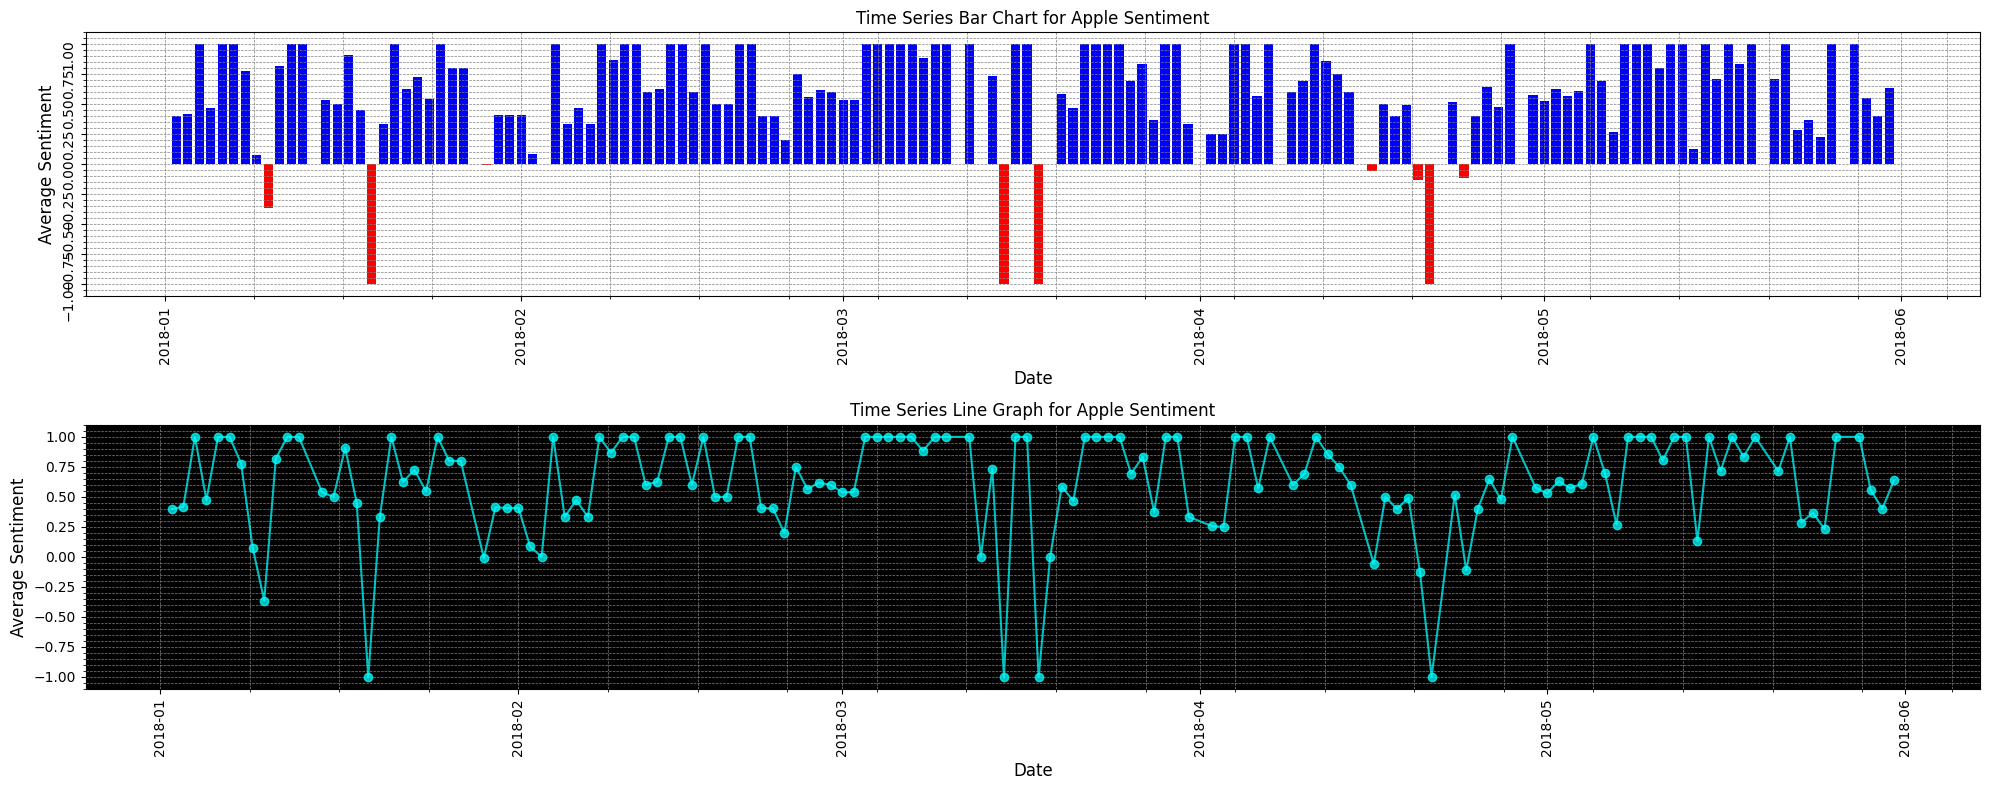

In [340]:
a = SentimentGraph('apple',sent_df)
a.get_sent_graphs()

In [283]:
b = StockPriceDataFrame('aapl')

In [284]:
a_sp = b.get_stockprices()

In [285]:
m = MergedDataFrame(sent_df, a_sp)

In [286]:
m_df = m.get_merged_df()
m_df

,avg_sentiment,price,prior_2d,price_2d_lag,price_diff
2018-01-02,0.400000,172.26,2017-12-31,170.16,1.234133
2018-01-03,0.416667,172.23,2018-01-01,170.16,1.216502
2018-01-04,1.000000,173.03,2018-01-02,172.26,0.446999
2018-01-05,0.473684,175.00,2018-01-03,172.23,1.608314
2018-01-06,1.000000,174.35,2018-01-04,173.03,0.762873
...,...,...,...,...,...
2018-05-26,1.000000,187.60,2018-05-24,188.15,-0.292320
2018-05-28,1.000000,187.60,2018-05-26,187.60,0.000000
2018-05-29,0.555556,187.90,2018-05-27,187.60,0.159915
2018-05-30,0.400000,187.50,2018-05-28,187.60,-0.053305


In [345]:
c = Correlation(m_df)

In [346]:
c.get_corr()

There correlation between sentiment and stock price is 0.22.


0.22

<Figure size 1000x200 with 0 Axes>

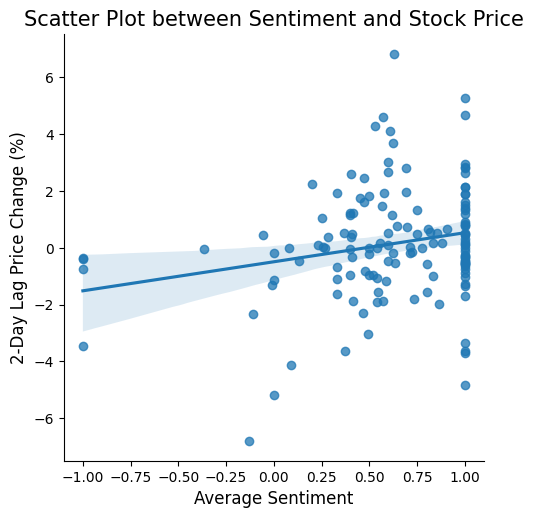

In [317]:
c.get_scatterplot()

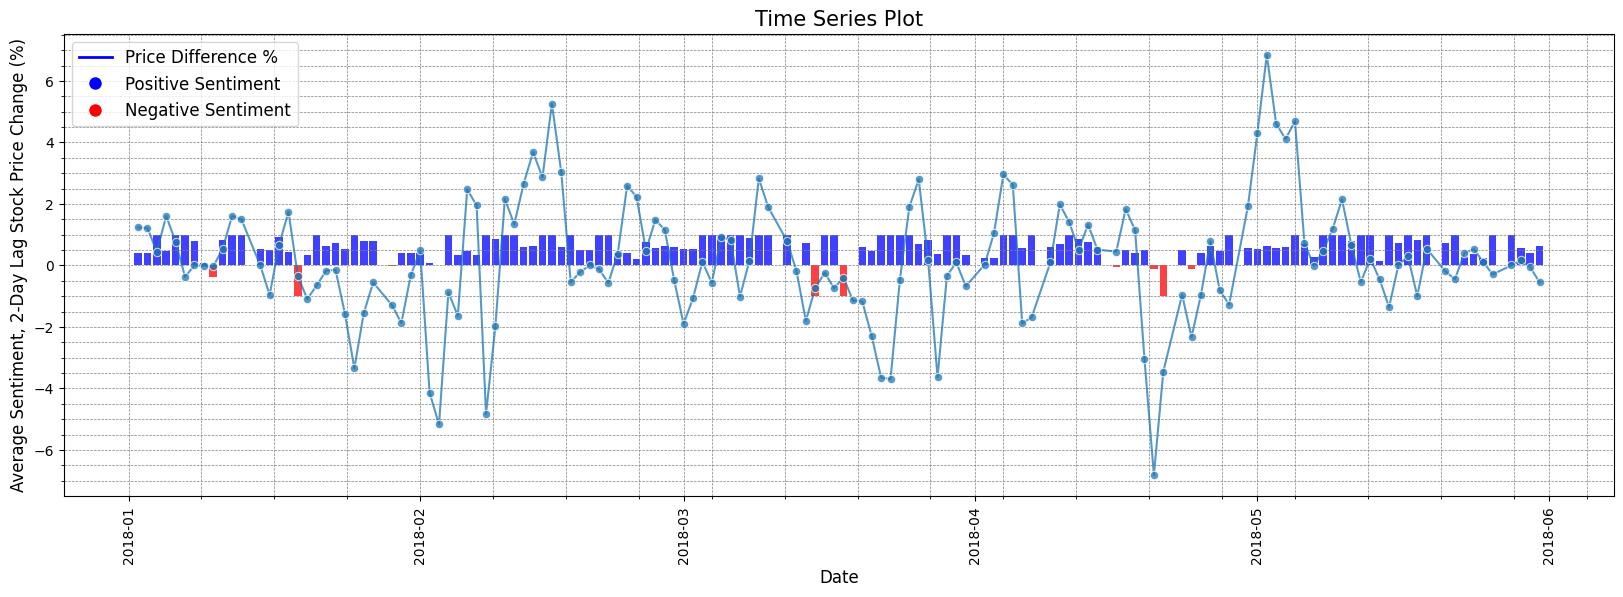

In [318]:
c.get_timeseriesplot()

#### test program using Apple & model 2

In [350]:
test_2 = SentimentDataFrames(df_news_processed,model_2)

note: codes below will take a while to run!

In [351]:
comp_df_2 = test_2.get_comp_df('apple')
comp_df_2

,date,newspaper,title,article,url,processed_article,processed_title,sentiment_sum,sentiment_count,year
0,2018-01-02,cnbc,Sell Apple on battery life canard? No!: Jim Cr...,Sell Apple on battery life canard? No!: Jim Cr...,https://www.cnbc.com/video/2018/01/02/sell-app...,[sell apple on battery life canard no jim cram...,"[sell, apple, on, battery, life, canard, no, j...",0.0,0,2018
1,2018-01-02,cnbc,Cramer Remix: My prediction for Apple in 2018,Cramer Remix: My prediction for Apple in 2018 ...,https://www.cnbc.com/video/2018/01/02/cramer-r...,[cramer remix my prediction for apple in 2018 ...,"[cramer, remix, my, prediction, for, apple, in...",1.0,1,2018
2,2018-01-02,cnbc,Cramer: Apple's iPhone 'batterygate' issue doe...,3 Hours Ago | 01:23 \nApple 's iPhone battery ...,https://www.cnbc.com/2018/01/02/cramer-apples-...,"[3 hours ago 01 23 , apple s iphone battery pr...","[cramer, apple, s, iphone, batterygate, issue,...",-2.0,2,2018
3,2018-01-02,fortune,Apple Admits To Slowing iPhones With Aging Bat...,An Apple Conspiracy Theory Blooms Poravute By ...,http://fortune.com/2018/01/02/an-apple-conspir...,[an apple conspiracy theory blooms poravute by...,"[apple, admits, to, slowing, iphones, with, ag...",-1.0,1,2018
4,2018-01-02,fortune,Trump's Tax Plan Means Apple Can Netflix and C...,By Hallie Detrick 9:20 AM EST \nThere’s a 40% ...,http://fortune.com/2018/01/02/apple-can-netfli...,"[by hallie detrick 9 20 am est , there s a 40 ...","[trump, s, tax, plan, means, apple, can, netfl...",3.0,3,2018
...,...,...,...,...,...,...,...,...,...,...
1352,2018-05-31,cnbc,Evergreen Bets Big on Disrupting the IT Market...,SAN FRANCISCO--(BUSINESS WIRE)-- Evergreen Ser...,http://www.cnbc.com/2018/05/31/business-wire-e...,[san francisco business wire evergreen service...,"[evergreen, bets, big, on, disrupting, the, it...",3.0,3,2018
1353,2018-05-31,reuters,Telegram says Apple has prevented it from upda...,"May 31, 2018 / 9:48 AM / a few seconds ago Tel...",https://www.reuters.com/article/us-russia-tele...,[may 31 2018 9 48 am a few seconds ago telegra...,"[telegram, says, apple, has, prevented, it, fr...",-4.0,4,2018
1354,2018-05-31,reuters,Apple cuts smartphone power chip orders from D...,"May 31, 2018 / 5:36 PM / Updated 3 hours ago A...",https://in.reuters.com/article/apple-power-chi...,[may 31 2018 5 36 pm updated 3 hours ago apple...,"[apple, cuts, smartphone, power, chip, orders,...",-4.0,4,2018
1355,2018-05-31,fortune,Telegram CEO Says Apple Refuses to Update App ...,The CEO of the secure-messaging app Telegram i...,http://fortune.com/2018/05/31/telegram-apple-a...,[the ceo of the secure messaging app telegram ...,"[telegram, ceo, says, apple, refuses, to, upda...",-6.0,6,2018


In [352]:
sent_df_2 = test_2.get_comp_sentiments()
sent_df_2

,avg_sentiment
date,
2018-01-02,-0.136364
2018-01-03,-0.515152
2018-01-04,0.071429
2018-01-05,-0.567568
2018-01-06,0.428571
...,...
2018-05-26,-1.000000
2018-05-28,1.000000
2018-05-29,-0.176471


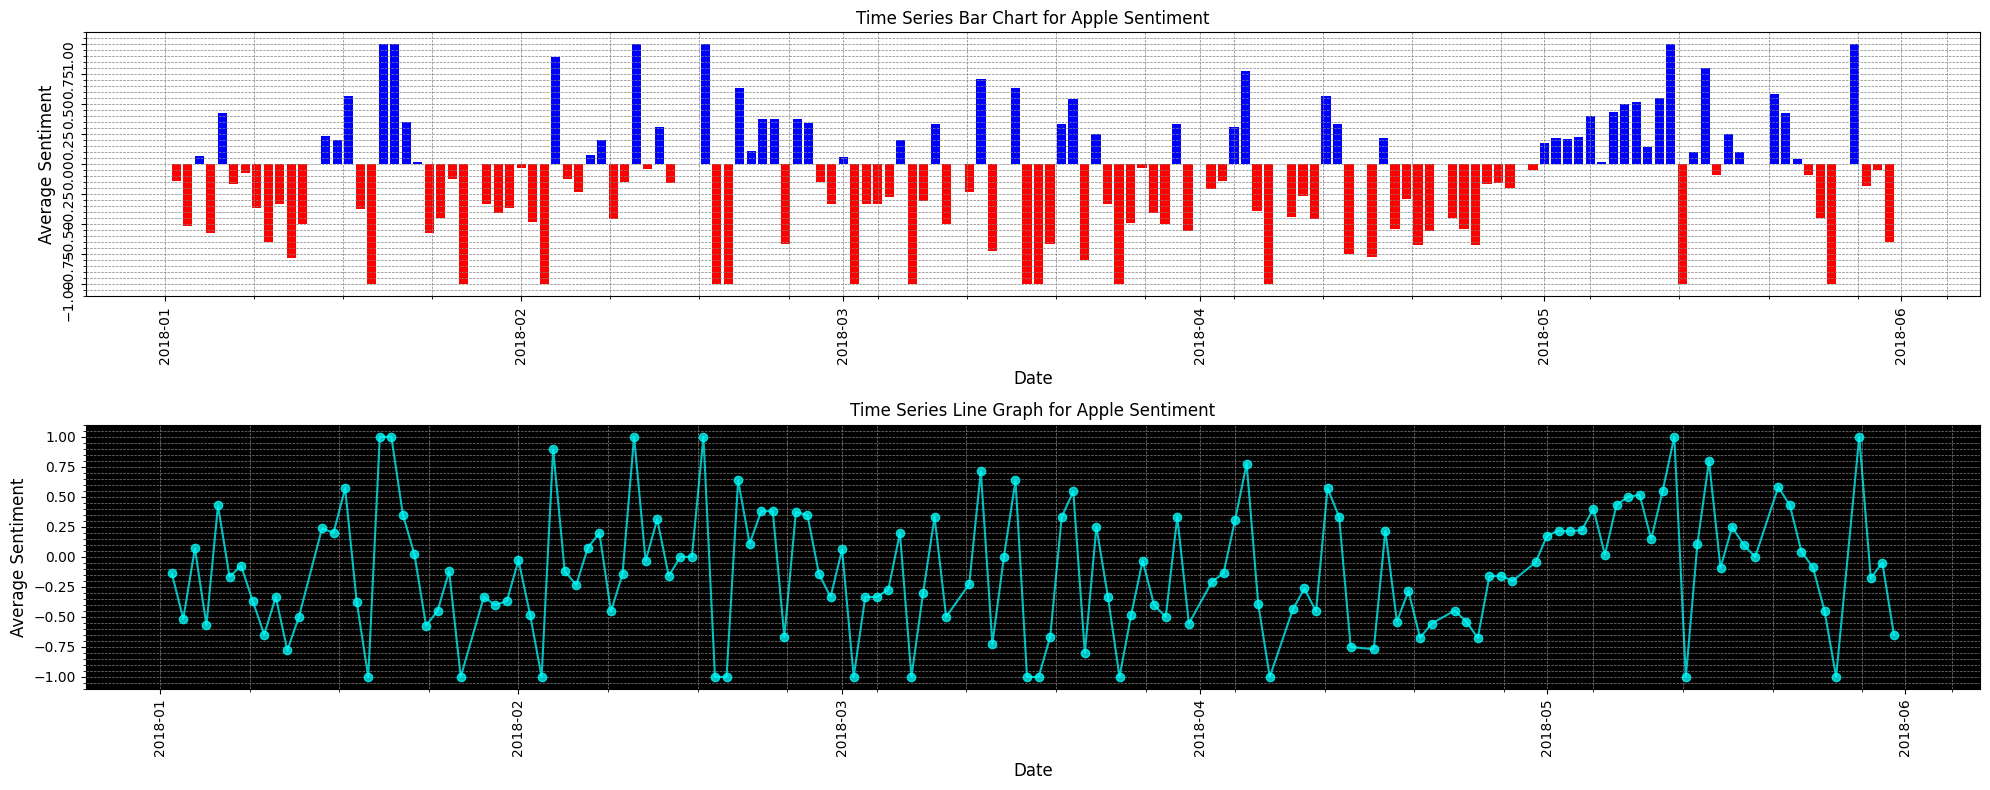

In [353]:
a_2 = SentimentGraph('apple',sent_df_2)
a_2.get_sent_graphs()

In [354]:
m = MergedDataFrame(sent_df_2, a_sp)
m_df_2 = m.get_merged_df()
m_df_2

,avg_sentiment,price,prior_2d,price_2d_lag,price_diff
2018-01-02,-0.136364,172.26,2017-12-31,170.16,1.234133
2018-01-03,-0.515152,172.23,2018-01-01,170.16,1.216502
2018-01-04,0.071429,173.03,2018-01-02,172.26,0.446999
2018-01-05,-0.567568,175.00,2018-01-03,172.23,1.608314
2018-01-06,0.428571,174.35,2018-01-04,173.03,0.762873
...,...,...,...,...,...
2018-05-26,-1.000000,187.60,2018-05-24,188.15,-0.292320
2018-05-28,1.000000,187.60,2018-05-26,187.60,0.000000
2018-05-29,-0.176471,187.90,2018-05-27,187.60,0.159915
2018-05-30,-0.047619,187.50,2018-05-28,187.60,-0.053305


In [356]:
c = Correlation(m_df_2)

In [357]:
c.get_corr()

There correlation between sentiment and stock price is 0.22.


0.22

<Figure size 1000x200 with 0 Axes>

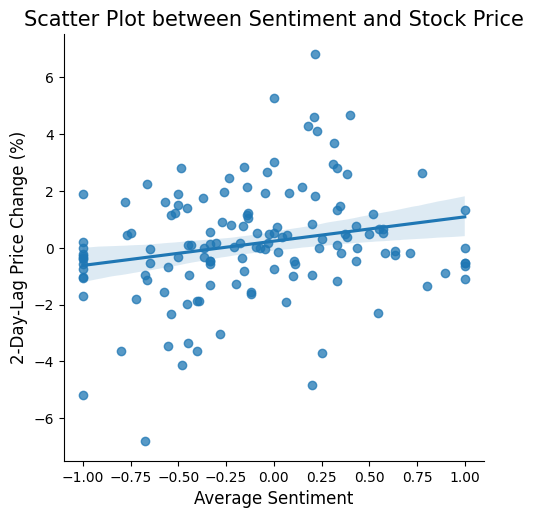

In [358]:
c.get_scatterplot()

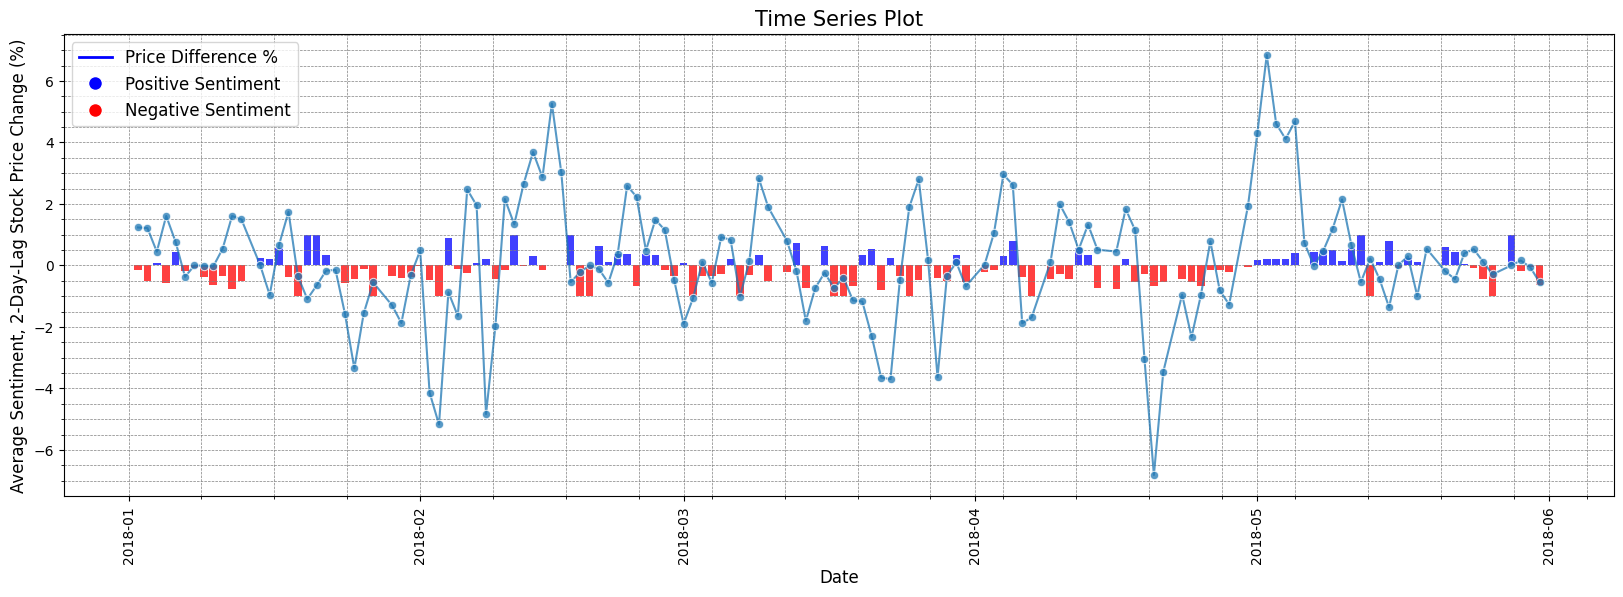

In [359]:
c.get_timeseriesplot()

#### test program using Tesla & model 1

In [123]:
test_3 = SentimentDataFrames(df_news_processed,model_1)

In [124]:
comp_df_3 = test_3.get_comp_df('tesla')
comp_df_3

,date,newspaper,title,article,url,processed_article,processed_title,sentiment_sum,sentiment_count,year
0,2018-01-02,cnbc,Tesla Model 3 challenges and cash burn may ove...,Tesla Model 3 challenges and cash burn may ove...,https://www.cnbc.com/video/2018/01/02/tesla-mo...,[tesla model 3 challenges and cash burn may ov...,"[tesla, model, 3, challenges, and, cash, burn,...",0.0,0,2018
1,2018-01-02,cnbc,Tesla Model 3 challenges and cash burn worries...,Tesla Model 3 challenges and cash burn worries...,https://www.cnbc.com/2018/01/02/tesla-model-3-...,[tesla model 3 challenges and cash burn worrie...,"[tesla, model, 3, challenges, and, cash, burn,...",0.0,2,2018
2,2018-01-02,cnbc,Elon Musk's Tesla tweets are a lesson in leade...,Tesla Motors CEO Elon Musk SHARES \nBillionair...,https://www.cnbc.com/2018/01/02/elon-musks-tes...,"[tesla motors ceo elon musk shares , billionai...","[elon, musk, s, tesla, tweets, are, a, lesson,...",1.0,1,2018
3,2018-01-03,cnbc,"Tesla falls short on Model 3, but overall sale...",DETROIT (AP) — Electric car maker Tesla Inc. h...,https://www.cnbc.com/2018/01/03/the-associated...,[detroit ap electric car maker tesla inc has a...,"[tesla, falls, short, on, model, 3, but, overa...",0.0,2,2018
4,2018-01-03,cnbc,UPDATE 3-Tesla pushes back Model 3 production ...,"(Adds analyst quotes, background)\nSAN FRANCIS...",https://www.cnbc.com/2018/01/03/reuters-americ...,"[ adds analyst quotes background , san francis...","[update, 3, tesla, pushes, back, model, 3, pro...",1.0,7,2018
...,...,...,...,...,...,...,...,...,...,...
883,2018-05-30,fortune,Consumer Reports Reverses Its Decision on Tesl...,By Kirsten Korosec 2:28 PM EDT\nConsumer Repor...,http://fortune.com/2018/05/30/consumer-reports...,"[by kirsten korosec 2 28 pm edt, consumer repo...","[consumer, reports, reverses, its, decision, o...",6.0,6,2018
884,2018-05-30,reuters,Consumer Reports recommends Tesla's Model 3 af...,"May 30, 2018 / 5:37 PM / Updated 13 minutes ag...",https://uk.reuters.com/article/uk-tesla-model-...,[may 30 2018 5 37 pm updated 13 minutes ago co...,"[consumer, reports, recommends, tesla, s, mode...",2.0,2,2018
885,2018-05-30,cnbc,Tesla in Autopilot mode hits parked California...,Tesla in Autopilot mode hits parked California...,https://www.cnbc.com/video/2018/05/30/tesla-au...,[tesla in autopilot mode hits parked californi...,"[tesla, in, autopilot, mode, hits, parked, cal...",-1.0,1,2018
886,2018-05-31,fortune,Tesla Denies Autopilot Is to Blame for Brussel...,Tesla has denied a report made earlier this we...,http://fortune.com/2018/05/31/tesla-brussels-a...,[tesla has denied a report made earlier this w...,"[tesla, denies, autopilot, is, to, blame, for,...",0.0,0,2018


In [125]:
t_sent_df = test_3.get_comp_sentiments()

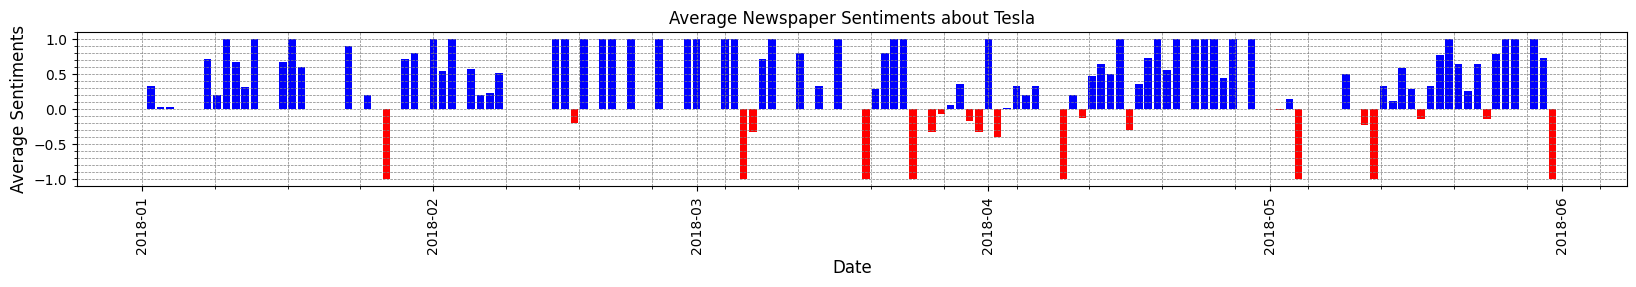

In [126]:
t = SentimentGraph('tesla',t_sent_df)
t.get_sent_graph()

In [184]:
t_spdf = StockPriceDataFrame('tsla')

In [185]:
t_sp = t_spdf.get_stockprices()

In [129]:
m = MergedDataFrame(t_sent_df, t_sp)
m_df = m.get_merged_df()
m_df

,date,avg_sentiment,close,prior_2d,close_2d,prior_3d,close_3d,price_diff_2d,price_diff_3d,price_diff
0,2018-01-02,0.333333,320.53,2017-12-31,NaN,2017-12-30,NaN,NaN,NaN,NaN
1,2018-01-03,0.027027,317.25,2018-01-01,NaN,2017-12-31,NaN,NaN,NaN,NaN
2,2018-01-04,0.034483,314.62,2018-01-02,320.53,2018-01-01,NaN,-1.843821,NaN,-1.843821
3,2018-01-05,NaN,316.58,2018-01-03,317.25,2018-01-02,320.53,-0.211190,-1.232334,-0.211190
4,2018-01-08,0.714286,336.41,2018-01-06,NaN,2018-01-05,316.58,NaN,6.263820,6.263820
...,...,...,...,...,...,...,...,...,...,...
116,2018-05-26,1.000000,NaN,2018-05-24,277.85,2018-05-23,279.07,NaN,NaN,NaN
117,2018-05-27,1.000000,NaN,2018-05-25,278.85,2018-05-24,277.85,NaN,NaN,NaN
118,2018-05-29,1.000000,283.76,2018-05-27,NaN,2018-05-26,NaN,NaN,NaN,NaN
119,2018-05-30,0.733333,291.72,2018-05-28,NaN,2018-05-27,NaN,NaN,NaN,NaN


In [130]:
m_df.price_diff.isna().sum()

49

In [135]:
c = Correlation(m_df)
c.get_corr()

There correlation between sentiment and stock price is 0.10.


0.1

<Figure size 1000x200 with 0 Axes>

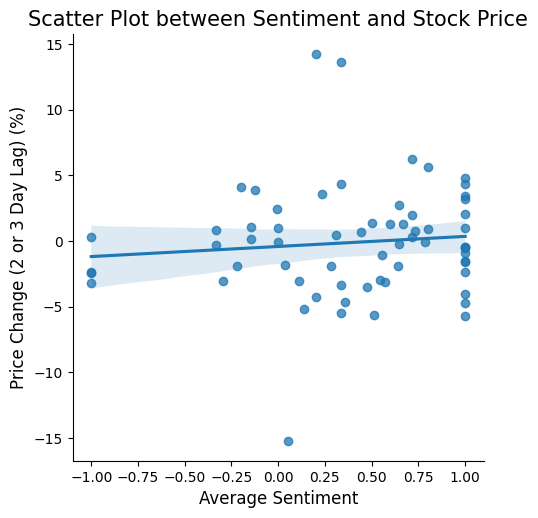

In [136]:
c.get_scatterplot()

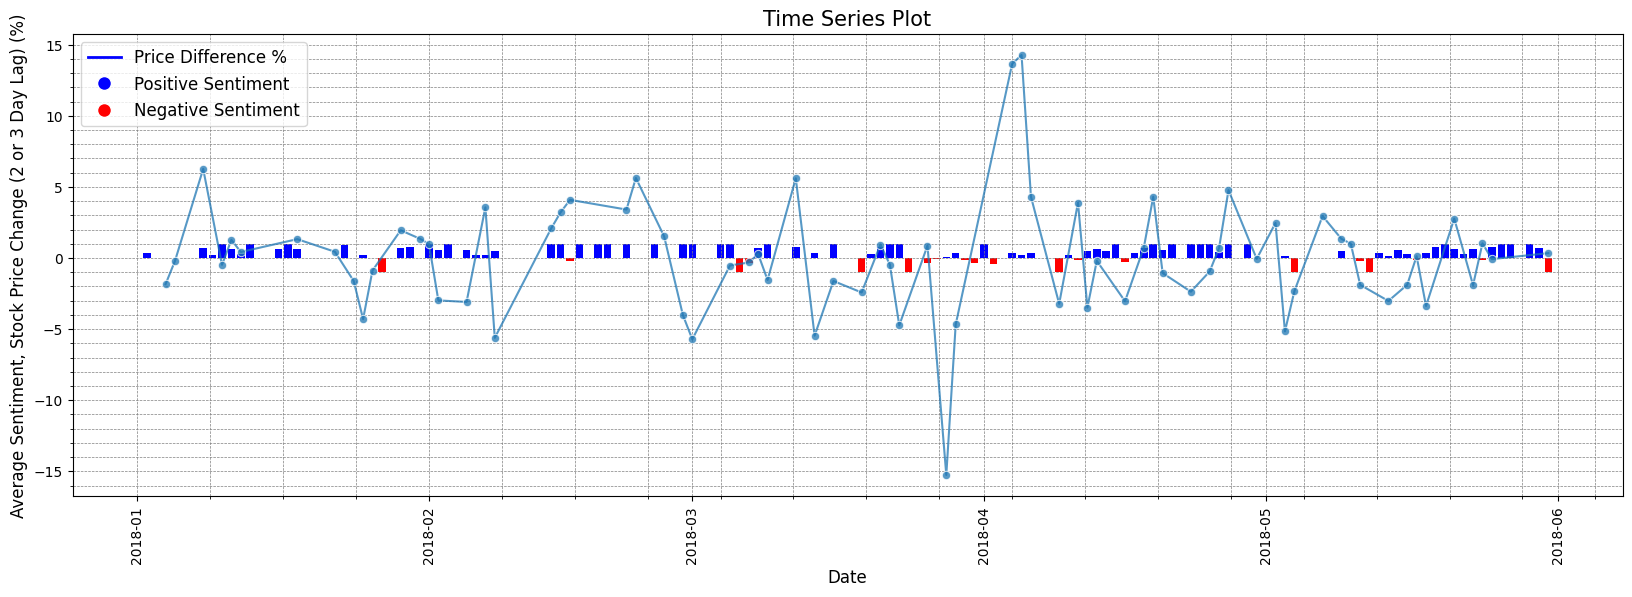

In [137]:
c.get_timeseriesplot()

#### test program using Tesla & model 2

In [138]:
test_4 = SentimentDataFrames(df_news_processed,model_2)

In [139]:
comp_df_4 = test_4.get_comp_df('tesla')
comp_df_4

,date,newspaper,title,article,url,processed_article,processed_title,sentiment_sum,sentiment_count,year
0,2018-01-02,cnbc,Tesla Model 3 challenges and cash burn may ove...,Tesla Model 3 challenges and cash burn may ove...,https://www.cnbc.com/video/2018/01/02/tesla-mo...,[tesla model 3 challenges and cash burn may ov...,"[tesla, model, 3, challenges, and, cash, burn,...",-1.0,1,2018
1,2018-01-02,cnbc,Tesla Model 3 challenges and cash burn worries...,Tesla Model 3 challenges and cash burn worries...,https://www.cnbc.com/2018/01/02/tesla-model-3-...,[tesla model 3 challenges and cash burn worrie...,"[tesla, model, 3, challenges, and, cash, burn,...",-2.0,8,2018
2,2018-01-02,cnbc,Elon Musk's Tesla tweets are a lesson in leade...,Tesla Motors CEO Elon Musk SHARES \nBillionair...,https://www.cnbc.com/2018/01/02/elon-musks-tes...,"[tesla motors ceo elon musk shares , billionai...","[elon, musk, s, tesla, tweets, are, a, lesson,...",0.0,2,2018
3,2018-01-03,cnbc,"Tesla falls short on Model 3, but overall sale...",DETROIT (AP) — Electric car maker Tesla Inc. h...,https://www.cnbc.com/2018/01/03/the-associated...,[detroit ap electric car maker tesla inc has a...,"[tesla, falls, short, on, model, 3, but, overa...",1.0,5,2018
4,2018-01-03,cnbc,UPDATE 3-Tesla pushes back Model 3 production ...,"(Adds analyst quotes, background)\nSAN FRANCIS...",https://www.cnbc.com/2018/01/03/reuters-americ...,"[ adds analyst quotes background , san francis...","[update, 3, tesla, pushes, back, model, 3, pro...",-3.0,11,2018
...,...,...,...,...,...,...,...,...,...,...
883,2018-05-30,fortune,Consumer Reports Reverses Its Decision on Tesl...,By Kirsten Korosec 2:28 PM EDT\nConsumer Repor...,http://fortune.com/2018/05/30/consumer-reports...,"[by kirsten korosec 2 28 pm edt, consumer repo...","[consumer, reports, reverses, its, decision, o...",2.0,10,2018
884,2018-05-30,reuters,Consumer Reports recommends Tesla's Model 3 af...,"May 30, 2018 / 5:37 PM / Updated 13 minutes ag...",https://uk.reuters.com/article/uk-tesla-model-...,[may 30 2018 5 37 pm updated 13 minutes ago co...,"[consumer, reports, recommends, tesla, s, mode...",4.0,8,2018
885,2018-05-30,cnbc,Tesla in Autopilot mode hits parked California...,Tesla in Autopilot mode hits parked California...,https://www.cnbc.com/video/2018/05/30/tesla-au...,[tesla in autopilot mode hits parked californi...,"[tesla, in, autopilot, mode, hits, parked, cal...",-1.0,1,2018
886,2018-05-31,fortune,Tesla Denies Autopilot Is to Blame for Brussel...,Tesla has denied a report made earlier this we...,http://fortune.com/2018/05/31/tesla-brussels-a...,[tesla has denied a report made earlier this w...,"[tesla, denies, autopilot, is, to, blame, for,...",-3.0,3,2018


In [140]:
t_sent_df = test_4.get_comp_sentiments()

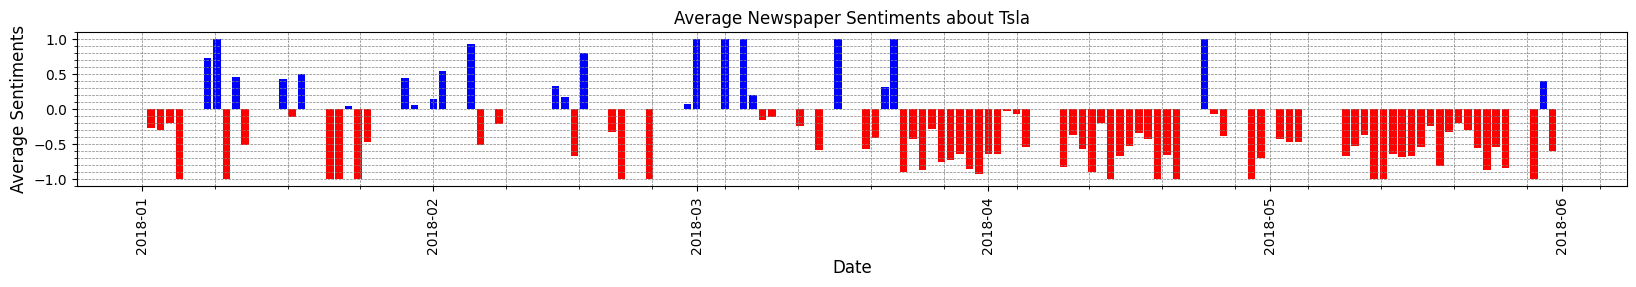

In [141]:
t_2 = SentimentGraph('tsla',t_sent_df)
t_2.get_sent_graph()

In [142]:
m = MergedDataFrame(t_sent_df, t_sp)
m_df = m.get_merged_df()
m_df

,date,avg_sentiment,close,prior_2d,close_2d,prior_3d,close_3d,price_diff_2d,price_diff_3d,price_diff
0,2018-01-02,-0.272727,320.53,2017-12-31,NaN,2017-12-30,NaN,NaN,NaN,NaN
1,2018-01-03,-0.295775,317.25,2018-01-01,NaN,2017-12-31,NaN,NaN,NaN,NaN
2,2018-01-04,-0.200000,314.62,2018-01-02,320.53,2018-01-01,NaN,-1.843821,NaN,-1.843821
3,2018-01-05,-1.000000,316.58,2018-01-03,317.25,2018-01-02,320.53,-0.211190,-1.232334,-0.211190
4,2018-01-08,0.733333,336.41,2018-01-06,NaN,2018-01-05,316.58,NaN,6.263820,6.263820
...,...,...,...,...,...,...,...,...,...,...
116,2018-05-26,-0.842105,NaN,2018-05-24,277.85,2018-05-23,279.07,NaN,NaN,NaN
117,2018-05-27,0.000000,NaN,2018-05-25,278.85,2018-05-24,277.85,NaN,NaN,NaN
118,2018-05-29,-1.000000,283.76,2018-05-27,NaN,2018-05-26,NaN,NaN,NaN,NaN
119,2018-05-30,0.400000,291.72,2018-05-28,NaN,2018-05-27,NaN,NaN,NaN,NaN


In [143]:
m_df.price_diff.isna().sum()

49

In [144]:
c = Correlation(m_df)
c.get_corr()

There correlation between sentiment and stock price is 0.11.


0.11

<Figure size 1000x200 with 0 Axes>

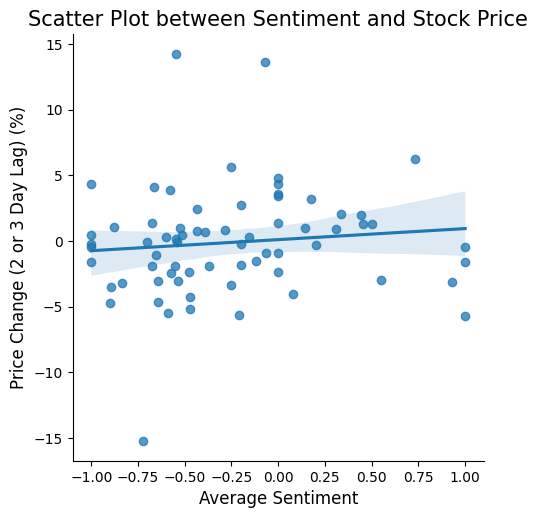

In [145]:
c.get_scatterplot()

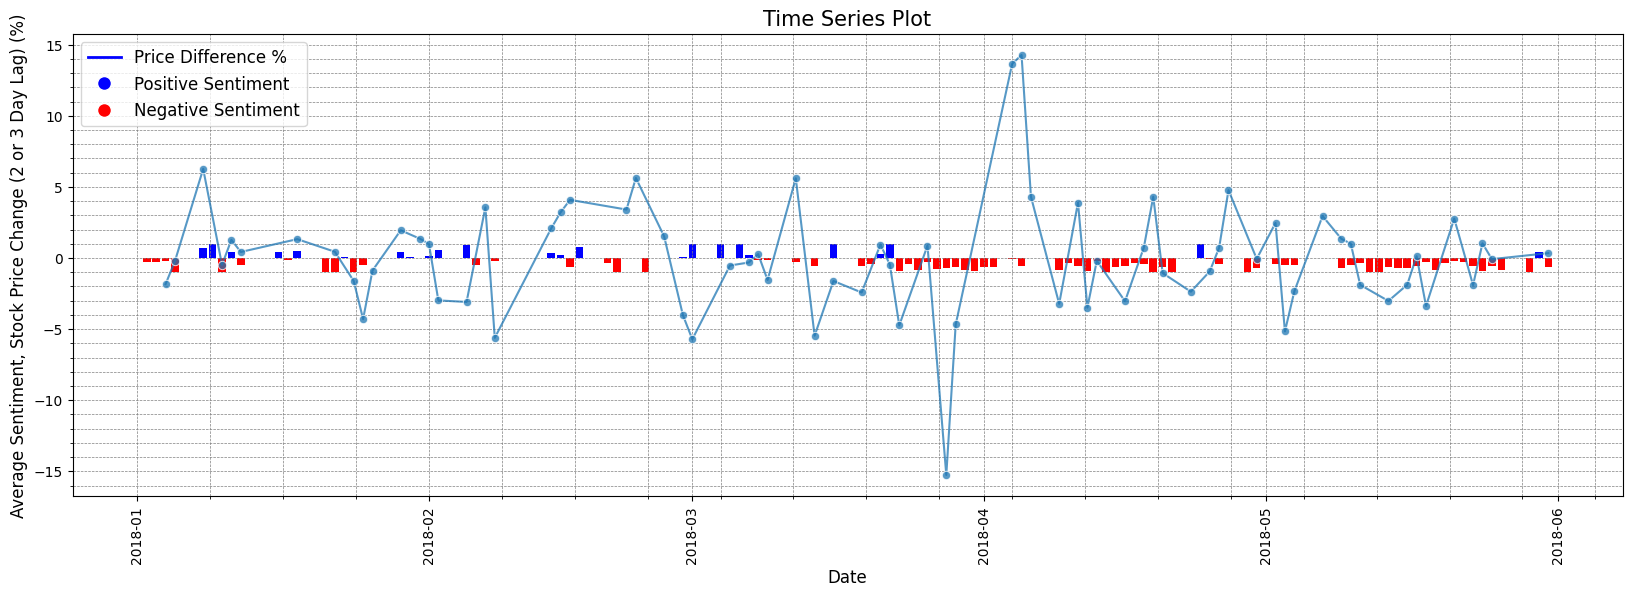

In [146]:
c.get_timeseriesplot()